#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Master Thesis/OcceanPlatformControl

!pip install ipython-autotime > /dev/null
!pip install torchinfo > /dev/null
%load_ext autotime

import numpy as np
import pandas as pd
import scipy
import math
import sys
import platform
import random
from tqdm import tqdm

import torch


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


SEED = 2022
torch.manual_seed(SEED)
#torch.use_deterministic_algorithms(True)
random.seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    print('')
    print('\x1b[32mGPU activated.\x1b[0m')
    !nvidia-smi -L
else:
    print('')
    print('\x1b[31mNo GPU available.\x1b[0m')

# T4 (0.25TFLOPS)< K80 (1.9TFLOPs) < P100 (5 TFLOPS) < V100 (8 TFLOPS)

print('')
print('Python Version:', platform.python_version())
print('Torch Version:', torch.__version__)
print('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master Thesis/OcceanPlatformControl
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime

GPU activated.
GPU 0: Tesla T4 (UUID: GPU-5e8a54e6-793c-4f9a-e6c7-fdef1569c0d1)

Python Version: 3.7.13
Torch Version: 1.11.0+cu113

time: 4.18 s (started: 2022-05-21 08:08:29 +00:00)


#Data Generation

In [ ]:
import os

MAX_DATA = 5760-5
TRUE_CURRENT_LENGTH = 5

trajectory_df = pd.read_csv('data/value_function_imitation_learning/trajectory.csv', index_col=0)

x_all = np.zeros((0,TRUE_CURRENT_LENGTH*4+15*15))
y_all = np.zeros((0,3*3))

for i in tqdm(range(TRUE_CURRENT_LENGTH, min(TRUE_CURRENT_LENGTH+MAX_DATA, len(trajectory_df.index)), 10)):
    true_currents = trajectory_df[['lon', 'lat', 'u_true', 'v_true']].iloc[i-5:i].values
    true_currents[:,:2] = true_currents[:,:2] - np.ones((5,2)) * trajectory_df[['lon', 'lat']].iloc[i].values
    ttr_map_in = pd.read_csv(f'data/value_function_imitation_learning/HYCOM/{i}.csv', index_col=0).to_numpy()
    ttr_map_out = pd.read_csv(f'data/value_function_imitation_learning/Copernicus/{i}.csv', index_col=0).to_numpy() - ttr_map_in[7:10, 7:10]

    x = np.concatenate((true_currents.flatten(), ttr_map_in.flatten()))
    y = ttr_map_out.flatten()

    x_all = np.append(x_all, np.expand_dims(x.squeeze(), axis=0), axis=0)
    y_all = np.append(y_all, np.expand_dims(y.squeeze(), axis=0), axis=0)

print(x_all.shape)
print(y_all.shape)

with open('data/value_function_imitation_learning/x_all.npy', 'wb') as f:
    np.save(f, x_all)
with open('data/value_function_imitation_learning/y_all.npy', 'wb') as f:
    np.save(f, y_all)


100%|██████████| 576/576 [00:04<00:00, 119.96it/s]

(576, 245)
(576, 9)
time: 4.93 s (started: 2022-05-20 23:20:48 +00:00)


#Load Data

In [ ]:
with open('data/value_function_learning/x_all.npy', 'rb') as f:
    x_all = np.load(f)
with open('data/value_function_learning/y_all.npy', 'rb') as f:
    y_all = np.load(f)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=SEED)

x_all = torch.tensor(x_all, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.float32)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f'All:   {x_all.shape},   {y_all.shape}')
print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test:  {x_test.shape},  {y_test.shape}')

All:   torch.Size([576, 245]),   torch.Size([576, 9])
Train: torch.Size([518, 245]), torch.Size([518, 9])
Test:  torch.Size([58, 245]),  torch.Size([58, 9])
time: 27.8 ms (started: 2022-05-21 07:41:49 +00:00)


#Network

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary

num_samples = 20
input_size = x_train.shape[1]
layer_size = 10
output_size = y_train.shape[1]

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        #self.relu1 = nn.ReLU()

        self.dense1 = nn.Linear(in_features=29, out_features=layer_size)
        #self.relu2 = nn.ReLU()
        self.dense2 = nn.Linear(in_features=layer_size, out_features=output_size)

    def angle_from_grid(grid):
        # grid: 3x3 tensor
        # angle: 1 tensor
        

    def forward(self, input):
        true_currents = torch.reshape(input[:, :5*4], (-1, 20))
        ttr_map = torch.reshape(input[:, -15*15:], (-1, 1, 15, 15))

        ttr_map = self.conv1(ttr_map)
        ttr_map = self.conv2(ttr_map)
        ttr_map = torch.flatten(ttr_map, start_dim=1)

        # activationfunction for CNN

        fc = torch.cat((true_currents, ttr_map), axis=1)



        grid = self.dense2(self.relu(self.dense1(fc)))

        return angle_from_grid(grid)

        return grid

model = Model()
test_input = torch.unsqueeze(x_train[0], 0)
print(f'x_train:   {test_input.shape}')
print(f'model_out: {model(test_input).shape}')


summary(model, input_size=(1, 245))

x_train:   torch.Size([1, 245])
model_out: torch.Size([1, 9])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Conv2d: 1-1                            [1, 1, 7, 7]              10
├─Conv2d: 1-2                            [1, 1, 3, 3]              10
├─Linear: 1-3                            [1, 10]                   300
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 9]                    99
Total params: 419
Trainable params: 419
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

time: 54.9 ms (started: 2022-05-21 08:38:49 +00:00)


#Train

In [ ]:
n_epochs = 100
batch_size = 128

model = Model()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)

loss_history = []

for epoch in range(n_epochs):

    permutation = torch.randperm(x_train.size()[0])

    for i in range(0, x_train.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]

        batch_output = model(batch_x)
        loss = loss_function(batch_output, batch_y)

        loss.backward()
        optimizer.step()

    train_loss = loss_function(model(x_train), y_train)
    test_loss = loss_function(model(x_test), y_test)
    loss_history.append(test_loss)
    
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, train loss: {train_loss.item():.2f}, test loss: {test_loss.item():.2f}')

epoch: 0, train loss: 1168.78, test loss: 1082.66
epoch: 10, train loss: 64.59, test loss: 71.98
epoch: 20, train loss: 9.17, test loss: 8.85
epoch: 30, train loss: 6.97, test loss: 7.18
epoch: 40, train loss: 13.27, test loss: 14.53
epoch: 50, train loss: 5.18, test loss: 5.01
epoch: 60, train loss: 7.16, test loss: 6.40
epoch: 70, train loss: 6.21, test loss: 4.28
epoch: 80, train loss: 7.61, test loss: 8.50
epoch: 90, train loss: 5.95, test loss: 5.42
time: 1.92 s (started: 2022-05-21 08:39:21 +00:00)


#Model Analysis

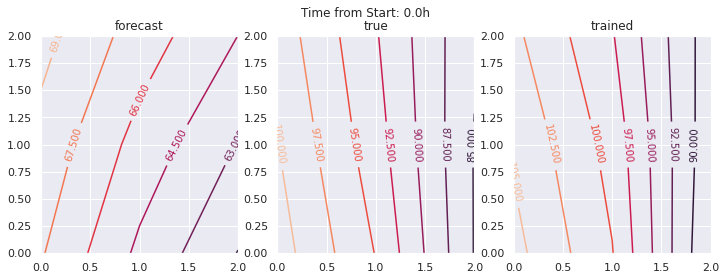

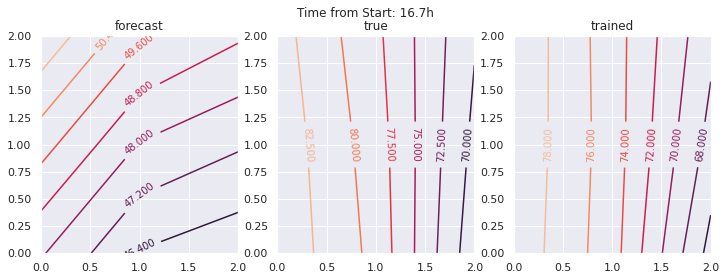

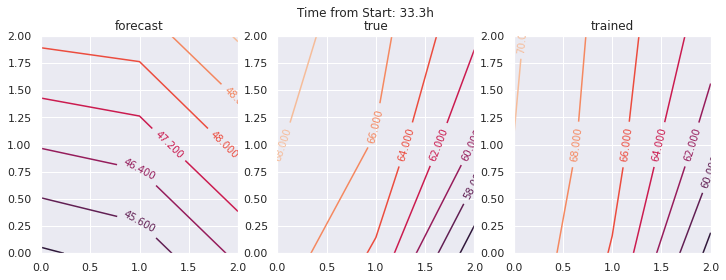

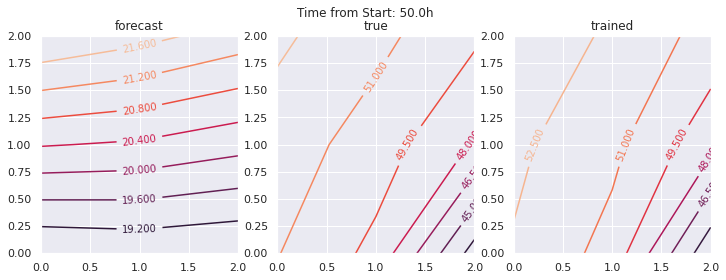

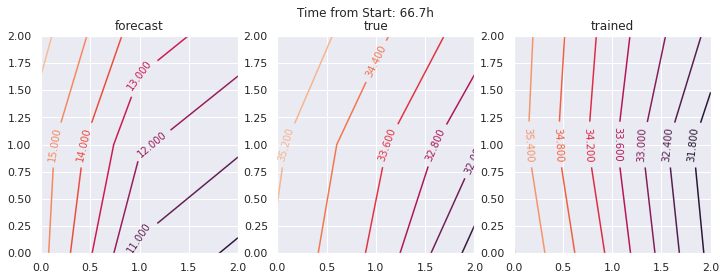

time: 6.04 s (started: 2022-05-21 07:56:50 +00:00)


In [ ]:
def plot_contour(ax, val, title):
    CS = ax.contour(np.arange(val.shape[0]), np.arange(val.shape[1]), val)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(title)

def plot_forecast_true_trained(x, y, model, time):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    forecast = torch.reshape(x[-15*15:], (15, 15))
    plot_contour(ax1, forecast.numpy()[7:10,7:10], 'forecast')

    true = forecast[7:10,7:10] + torch.reshape(y, (3, 3))
    plot_contour(ax2, true.numpy(), 'true')

    after = forecast[7:10, 7:10] + torch.reshape(model(torch.unsqueeze(x,0))[0], (3,3))
    plot_contour(ax3, after.detach().numpy(), 'trained')

    fig.suptitle(f'Time from Start: {time:.1f}h')
    plt.show()

for i in range(5):
    plot_forecast_true_trained(x_all[100*i], y_all[100*i], model, 100*i/6)